In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [7]:
# bring in betting odds

odds = {}

for i in range(1, 19):
    odds[i] = pd.read_csv(f'data/nfl-odds-rotowire-{i:02}.csv', header=1) \
        .set_index('Team') \
        [['Moneyline']]

In [8]:
# convert odds to probs

probs = []
for i in range(1, 19):
    tmp = odds[i] \
        .assign(prob = lambda d: np.where(d['Moneyline'] > 0, 100 / (d['Moneyline'] + 100), -d['Moneyline'] / (-d['Moneyline'] + 100))) \
        .assign(week = i) \
        [['week', 'prob']]
    probs.append(tmp)
    
probs = pd.concat(probs)
probs

,week,prob
Team,,
Lions,1,0.294118
Chiefs,1,0.733333
Panthers,1,0.393701
Falcons,1,0.637681
Texans,1,0.210526
...,...,...
49ers,18,0.748744
Jaguars,18,0.565217
Titans,18,0.476190


In [84]:
# list of teams, by divisions and overall

divisions = {}

divisions['NFCN'] = ['Lions', 'Vikings', 'Packers', 'Bears']
divisions['NFCE'] = ['Eagles', 'Cowboys', 'Giants', 'Commanders']
divisions['NFCS'] = ['Saints', 'Falcons', 'Panthers', 'Buccaneers']
divisions['NFCW'] = ['49ers', 'Seahawks', 'Rams', 'Cardinals']

divisions['AFCN'] = ['Bengals', 'Ravens', 'Browns', 'Steelers']
divisions['AFCE'] = ['Bills', 'Dolphins', 'Jets', 'Patriots']
divisions['AFCS'] = ['Jaguars', 'Colts', 'Texans', 'Titans']
divisions['AFCW'] = ['Chiefs', 'Chargers', 'Broncos', 'Raiders']

all_teams = [
    'Lions', 'Vikings', 'Packers', 'Bears',
    'Eagles', 'Cowboys', 'Giants', 'Commanders',
    'Saints', 'Falcons', 'Panthers', 'Buccaneers',
    '49ers', 'Seahawks', 'Rams', 'Cardinals',
    'Bengals', 'Ravens', 'Browns', 'Steelers',
    'Bills', 'Dolphins', 'Jets', 'Patriots',
    'Jaguars', 'Colts', 'Texans', 'Titans',
    'Chiefs', 'Chargers', 'Broncos', 'Raiders'
    ]

In [ ]:
# ESPN probs (not using anymore)
dal_probs = [
    .530,
    .533,
    .707,
    .611,
    .448,
    .420,
    -1, 
    .705,
    .413,
    .602,
    .631,
    .642,
    .616,
    .491,
    .401,
    .471,
    .570,
    .577
]
phi_probs = [
    .617,
    .642,
    .761,
    .682,
    .649,
    .536,
    .579,
    .660,
    .583,
    -1,
    .433,
    .493,
    .572,
    .505,
    .583,
    .636,
    .803,
    .618
]

In [29]:
# set prob to -1 for bye weeks (as sentinel) 
d1 = {
    'week': [i for i in range(1,19)]
    }
d2 = {
    'Team': [team for team in all_teams]
}
bye_df = pd.merge(
    pd.DataFrame(d1),
    pd.DataFrame(d2),
    how='cross'
)
bye_df = bye_df.assign(prob=-1)

probs = pd.merge(bye_df, probs, on=['week', 'Team'], how='left') \
    .assign(
        prob = lambda d: np.where(d['prob_y'].isnull(), d['prob_x'], d['prob_y'])
        ) \
    [['Team', 'week', 'prob']]
probs

,week,Team,prob
0,1,Lions,-1
1,1,Vikings,-1
2,1,Packers,-1
3,1,Bears,-1
4,1,Eagles,-1
...,...,...,...
571,18,Titans,-1
572,18,Chiefs,-1
573,18,Chargers,-1
574,18,Broncos,-1


In [54]:
def sim(team):
    N = 1_000_000
    wins_per_week = {k: [] for k in range(1,19)}
    probs_team = probs.loc[probs['Team'] == team] \
        .sort_values(['week']) \
        ['prob'] \
        .to_list()
    
    for iter in range(N):
        wins = 0
        for week in range(1, 19):

            prob = probs_team[week-1]

            # random
            p = random.random()
            if prob == -1:
                # bye week
                pass
            elif p < prob:
                wins += 1

            wins_per_week[week].append(wins)

    return wins_per_week

In [129]:
# grab colors
team_colors = pd.read_csv("data/teams_colors_logos.csv")
team_colors = team_colors \
    .assign(team = lambda d: d['team_name'].str.split().str[-1]) \
    [['team', 'team_color', 'team_color2']] \
    .drop_duplicates()
team_colors

,team,team_color,team_color2
0,Cardinals,#97233F,#000000
1,Falcons,#A71930,#000000
2,Ravens,#241773,#9E7C0C
3,Bills,#00338D,#C60C30
4,Panthers,#0085CA,#000000
5,Bears,#0B162A,#E64100
6,Bengals,#FB4F14,#000000
7,Browns,#FF3C00,#311D00
8,Cowboys,#002244,#B0B7BC
9,Broncos,#002244,#FB4F14


In [93]:
def get_team_plot_data(team):
    wins_team = sim(team)

    team_wins_per_week = [np.mean(wins_team[k]) for k in range(1,19)]
    team_wins_per_week_lb = [np.mean(wins_team[k]) - np.std(wins_team[k]) for k in range(1,19)]
    team_wins_per_week_ub = [np.mean(wins_team[k]) + np.std(wins_team[k]) for k in range(1,19)]

    return (team_wins_per_week, team_wins_per_week_lb, team_wins_per_week_ub)


In [126]:
a = [1, 4, 3, 2]
b = ['Eagles', 'Commanders', 'Giants', 'Cowboys']
c = zip(a, b)
res = sorted(list(c), key=lambda tup: tup[0])
res

[(1, 'Eagles'), (2, 'Cowboys'), (3, 'Giants'), (4, 'Commanders')]

In [139]:
# TODO: order legend by week 18 mean?

def graph_division(div):
    fig, ax = plt.subplots()
    teams = divisions[div]
    wins_mean = {}
    wins_lb = {}
    wins_ub = {}
    wins_mean_list = []

    for i, team in enumerate(teams):

        (wins_mean[team], wins_lb[team], wins_ub[team]) = get_team_plot_data(team)
        wins_mean_list.append(wins_mean[team][-1])

    zipped = zip(teams, wins_mean_list)
    zipped = sorted(list(zipped), key=lambda tup: tup[1], reverse=True)

    for (team, _) in zipped:
        if team in ['Bears', 'Falcons', 'Browns', 'Texans', 'Titans', 'Broncos']:
            team_col = team_colors.loc[team_colors['team'] == team]['team_color2'].values[0]
        else:
            team_col = team_colors.loc[team_colors['team'] == team]['team_color'].values[0]

        ax.plot(wins_mean[team], color=team_col, linewidth=4, label=team)
        ax.plot(wins_lb[team], color=team_col, alpha=0.4, linestyle='dashed')
        ax.plot(wins_ub[team], color=team_col, alpha=0.4, linestyle='dashed')
    ax.legend()
    
    plt.yticks(np.arange(18))
    plt.xticks(ticks=np.arange(18), labels=np.arange(1,19))
    plt.title(f"Race for the {div} Crown")
    plt.xlabel("Weeks Completed")
    plt.ylabel("Games Won")
    plt.grid(color='k', linestyle='-', alpha=0.1)
    #plt.legend(teams)
    #cwd = os.getcwd()
    #subfolder = os.path.join(cwd, 'plots')
    #fname = os.path.join(subfolder, f"{div}_{team.upper()}")
    plt.savefig(f"plots/{div}.png")



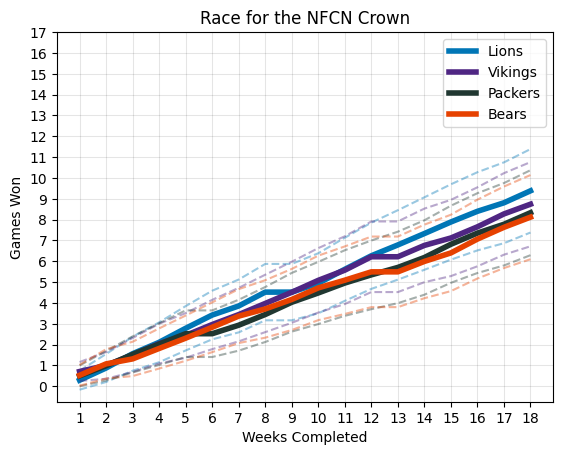

In [135]:
graph_division('NFCN')

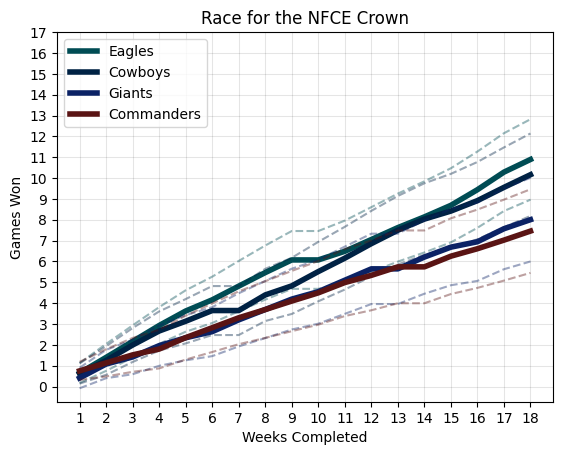

In [116]:
graph_division('NFCE')

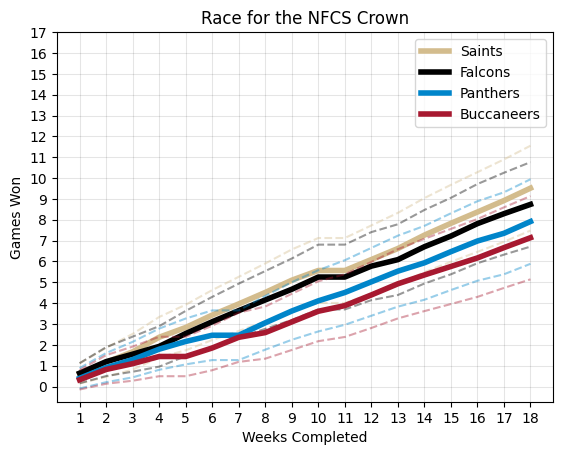

In [136]:
graph_division('NFCS')

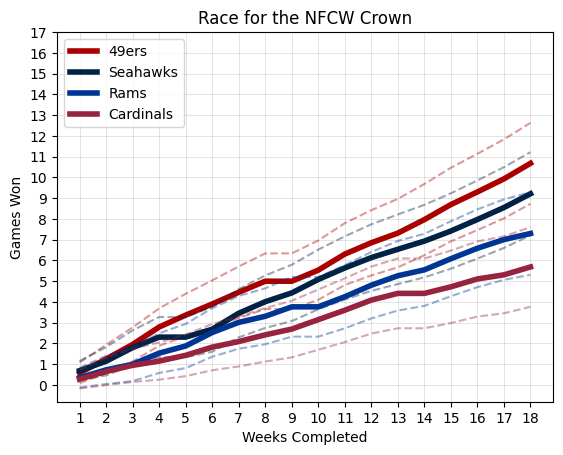

In [118]:
graph_division('NFCW')

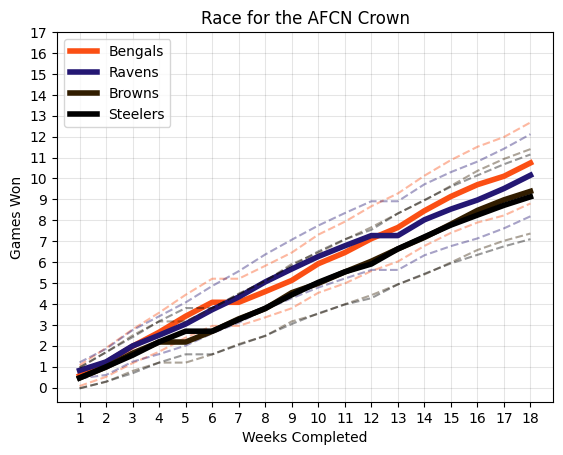

In [137]:
graph_division('AFCN')

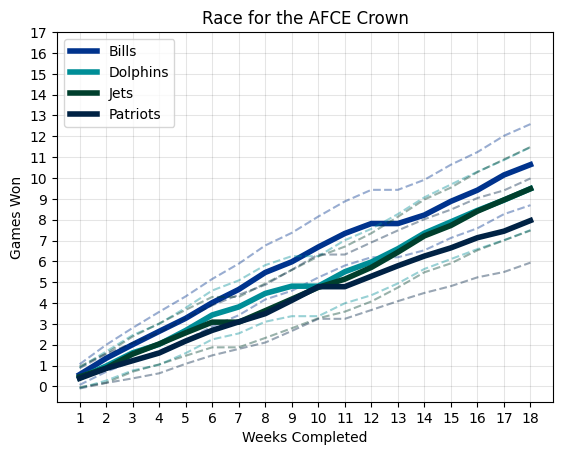

In [120]:
graph_division('AFCE')

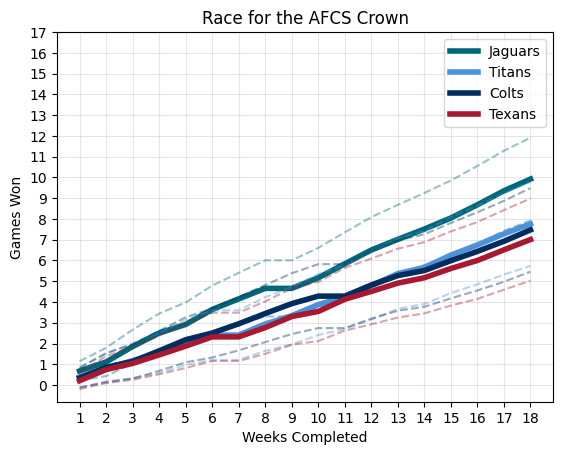

In [138]:
graph_division('AFCS')

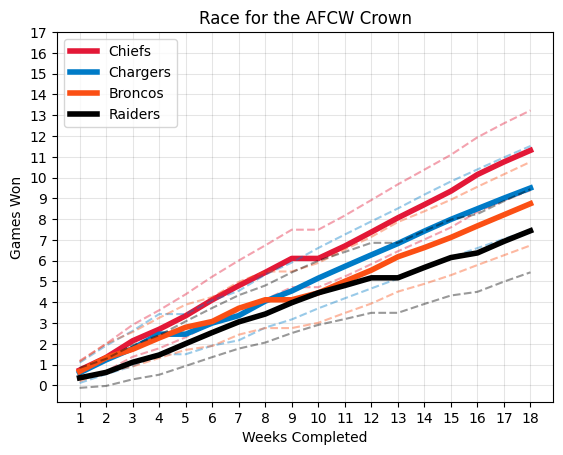

In [140]:
graph_division('AFCW')

In [95]:
#FIXME
def graph_all():
    fig, axs = plt.subplots(2, 4, sharex=True, sharey=True)

    plt.yticks(np.arange(18))
    plt.xticks(ticks=np.arange(18), labels=np.arange(1,19))
    plt.title(f"Race for the Crown")
    plt.xlabel("Weeks Completed")
    plt.ylabel("Games Won")
    plt.grid(color='k', linestyle='-', alpha=0.1)

    conferences = ['N', 'A']
    conf_div = ['N', 'S', 'E', 'W']

    for i, conf in enumerate(conferences):
        for j, div in enumerate(conf_div):
            if i != 0 and j != 0:
                continue
            else:
                teams = divisions[conf + 'FC' + div]
                ax = axs[i,j]

                for team in teams:
                    (wins_mean, wins_lb, wins_ub) = get_team_plot_data(team)
                    team_col = team_colors.loc[team_colors['team'] == team]['team_color'].values[0]

                    ax.plot(wins_mean, color=team_col, linewidth=4)
                    ax.plot(wins_lb, color=team_col, alpha=0.4, linestyle='dashed')
                    ax.plot(wins_ub, color=team_col, alpha=0.4, linestyle='dashed')
                ax.set_title(conf + 'FC' + div)
    
    plt.show()

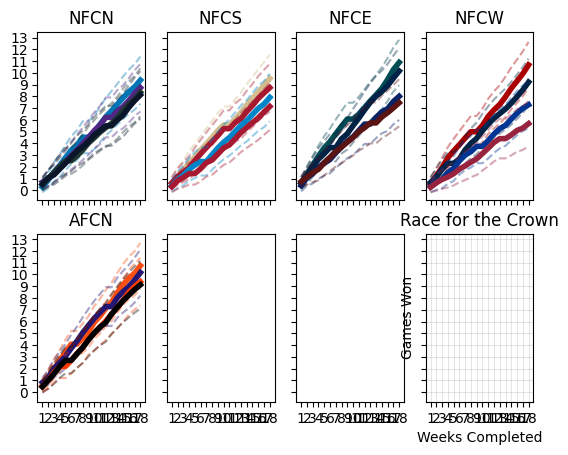

In [96]:
graph_all()